In [1]:
!pip install evaluate
!pip install datasets
!pip install fsspec==2023.9.2
from datasets import Dataset, load_dataset,  DatasetDict


In [2]:
from google.colab import drive

from datasets import DatasetDict, ClassLabel
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from transformers import (
  AutoConfig,
  AutoTokenizer,
  AutoModelForSequenceClassification ## capa de clasificación
)
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import random
from datasets import DatasetDict, ClassLabel
import pandas as pd
import evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import classification_report
import numpy as np

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
ruta = 'data_for_trainning_encoder.parquet'
#ruta = '/content/drive/My Drive/TFM/data_for_trainning_encoder.parquet'

df = pd.read_parquet(ruta)

df=df[df['search']=='mercadona']
df


# ##subset aleatorio pero manteniendo proporcion en target
n = 2758
df['imagen_marca'] =df['imagen_marca'].astype(str).str.strip()
df_balanceado = (df.groupby('imagen_marca', group_keys=False).apply(lambda x: x.sample(n=n//2, random_state=69)))

df = df_balanceado


/tmp/ipython-input-2790313923.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanceado = (df.groupby('imagen_marca', group_keys=False).apply(lambda x: x.sample(n=n//2, random_state=69)))


In [5]:
df.columns

Index(['index', 'User', 'tweets', 'search', 'fecha_captura',
       'explica_sentimiento', 'explica_sentimiento_2', 'sentimiento_final',
       'proteccion_datos', 'deteccion_producto', 'producto',
       'sentimiento_producto', 'categoria', 'comparativa_producto',
       'comparativa_sentimiento', 'imagen_marca'],
      dtype='object')

In [6]:
#df['sentimiento_producto'] =df['sentimiento_producto'].astype(str).str.strip()
df['imagen_marca'].value_counts()

,count
imagen_marca,
NO,1379
SI,1379


In [7]:
#df['sentimiento_producto'].astype(str).str.strip().value_counts()

In [8]:
#nombre_modelo_nuevo= 'Spanish_twitter_sentiment_analysis_mini'


nombre_modelo_nuevo= 'mercadona_Brand_reference_detector'



In [9]:
df_for_training = df[['tweets', 'imagen_marca']].copy()

df_for_training = df_for_training.rename(columns={'tweets': 'text', 'imagen_marca':'labels' })
df_for_training['labels'] = (df_for_training['labels']
                              .astype(str)
                              .str.strip()
                              .str.upper()
                              .map({'SI': 1, 'NO': 0}))
df_for_training

,text,labels
8810,Parece que tengo ictericia con el puto autobro...,0
8121,es absurdo lo rico que está el té negro con ca...,0
8310,Me comprado unos tacones para ir al Mercadona ...,0
5968,La pareja delante de mi en el mercadona acaba ...,0
7049,"Señores del tiempo,en Mercadona buscan emplead...",0
...,...,...
6482,El pan integral 100% de mercadona es de los má...,1
6618,No hay nada que tenga menos haters que el merc...,1
7229,Mercadona puteros,1
9445,En la lista de cosas que extraño de España te ...,1


In [10]:
dataset = Dataset.from_pandas(df_for_training)
dataset

Dataset({
    features: ['text', 'labels', '__index_level_0__'],
    num_rows: 2758
})

In [11]:
model_name =  'Twitter/twhin-bert-large' #"BSC-LT/roberta-large-bne"   #base 'microsoft/mdeberta-v3-base' #'microsoft/mdeberta-v3-base'


tokenizer = AutoTokenizer.from_pretrained(model_name)#, use_fast=False ) #use_fast=False en modelos Plant-TL deverta b



def preprocess_function(examples):
    # Tokenizar el texto

    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=256) ##maxlen recomendado en deberta. No poner en resto si no da avisos

    #return tokenizer(examples['text'], padding="max_length", truncation=True)



dataset = dataset.map(preprocess_function, batched=True) # preprocess_function


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/2758 [00:00<?, ? examples/s]

In [12]:
# 1. División inicial: 90% train+dev, 10% test
split_1 = dataset.train_test_split(test_size=0.1, shuffle=True, seed=42)

# 2. División secundaria: de ese 90%, separamos 11.11% para validación → (10% del total original)
split_2 = split_1['train'].train_test_split(test_size=0.1111, shuffle=True, seed=69)

# 3. Armamos todo en un DatasetDict
final_splits = DatasetDict({
    'train': split_2['train'],
    'validation': split_2['test'],
    'test': split_1['test']
})

# 4. Verificación de tamaños
print(f"Train: {len(final_splits['train'])}")
print(f"Validation: {len(final_splits['validation'])}")
print(f"Test: {len(final_splits['test'])}")

Train: 2206
Validation: 276
Test: 276


In [13]:
from collections import Counter

def print_label_distribution(split_name, dataset):
    labels = dataset['labels']
    total = len(labels)
    counter = Counter(labels)
    print(f"Distribución en {split_name} (total {total}):")
    for label, count in counter.items():
        print(f"  Clase {label}: {count} ({count/total:.2%})")
    print()

# Asumiendo que tienes final_splits como DatasetDict
print_label_distribution('Train', final_splits['train'])
print_label_distribution('Validation', final_splits['validation'])
print_label_distribution('Test', final_splits['test'])

Distribución en Train (total 2206):
  Clase 0: 1102 (49.95%)
  Clase 1: 1104 (50.05%)

Distribución en Validation (total 276):
  Clase 0: 142 (51.45%)
  Clase 1: 134 (48.55%)

Distribución en Test (total 276):
  Clase 1: 141 (51.09%)
  Clase 0: 135 (48.91%)



In [14]:
dataset = final_splits

In [15]:
### modelo.

In [16]:
SEED = 69

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)



id2label = {0: "NO", 1: "SI"}
label2id = {"NO": 0, "SI": 1}



def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
    device_map="auto",


    trust_remote_code=True,
    # #hiden en modelo eurobert
    # hidden_dropout=0.1,
    # attention_dropout=0.1,

    #hiden en modelo roberta
    # para hacer dropout al modelo.
    #hidden_dropout_prob=0.1,  # dropout en capas ocultas cuando se activa afecta a la cabeza de clasificacion
    #attention_probs_dropout_prob=0.1,  # dropout en atención

    #classifier_dropout=0.3,     # dropout en clasificación para ajustar solamente la cabeza.

    )

model = model_init()
print(model.config)


# # imprimir layers entrenables
for name, param in model.named_parameters():
  print(name, param.requires_grad)

print(100*("="))
print('dropout')
# Verificar  dropout
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Dropout):
        print(f"{name}: {module}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Twitter/twhin-bert-large and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "NO",
    "1": "SI"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "NO": 0,
    "SI": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "relative_key",
  "torch_dtype": "float32",
  "transformers_version": "4.55.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 250002
}

bert.embeddings.word_embeddings.weight True
bert.embeddings.position_embeddings.weight True
bert.embeddings.token_type_embeddings.weight True
bert.embeddings.LayerNorm.weight True
bert.embeddings.LayerNorm.bias True
bert.encoder.layer.0.attention.self.query.weight True
bert.encoder.layer.0.attent

In [18]:
#NO-MODIFY: VARIABLE NAME
training_args =  TrainingArguments(
    output_dir=nombre_modelo_nuevo,
    learning_rate= 1e-05 , ### 2e-5  [1e-5, 1e-6, 1e-5,  2e-5, 3e-5, 1e-4 ] de minimos locales a no converger # 2e-5 estandar
    per_device_train_batch_size=8, #8
    per_device_eval_batch_size=8, #8
    num_train_epochs= 5,
    weight_decay=0.1,

    eval_strategy="steps",
    save_strategy="steps",
    #save_strategy="best",
    save_total_limit=None,
    save_steps=10,         # Cada paso
    eval_steps=10, #50,


    logging_strategy="steps",
    logging_steps=10, #50,

    load_best_model_at_end=True,
    push_to_hub=False,
    report_to="none",
    seed=SEED,
    metric_for_best_model="f1_score",
    greater_is_better=True,
    #bf16=True, #
    full_determinism=True,
    gradient_accumulation_steps=16 #

)

In [19]:
accuracy = evaluate.load("accuracy")
f1_score = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy_value = accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1_score_value = f1_score.compute(predictions=predictions, references=labels)["f1"]

    return {
        "accuracy": accuracy_value,
        "f1_score": f1_score_value,
    }

/tmp/ipython-input-1062857557.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Step,Training Loss,Validation Loss,Accuracy,F1 Score
10,0.692700,0.689059,0.485507,0.653659
20,0.676600,0.637906,0.666667,0.714286
30,0.630500,0.561365,0.731884,0.678261
40,0.555500,0.524980,0.713768,0.724739
50,0.531300,0.515612,0.757246,0.761566
60,0.503600,0.503150,0.764493,0.770318
70,0.481600,0.490436,0.782609,0.781022
80,0.460300,0.495025,0.771739,0.770909
90,0.461700,0.502244,0.775362,0.781690


{'eval_loss': 0.5022440552711487, 'eval_accuracy': 0.7753623188405797, 'eval_f1_score': 0.7816901408450704, 'eval_runtime': 14.7069, 'eval_samples_per_second': 18.767, 'eval_steps_per_second': 2.38, 'epoch': 5.0}


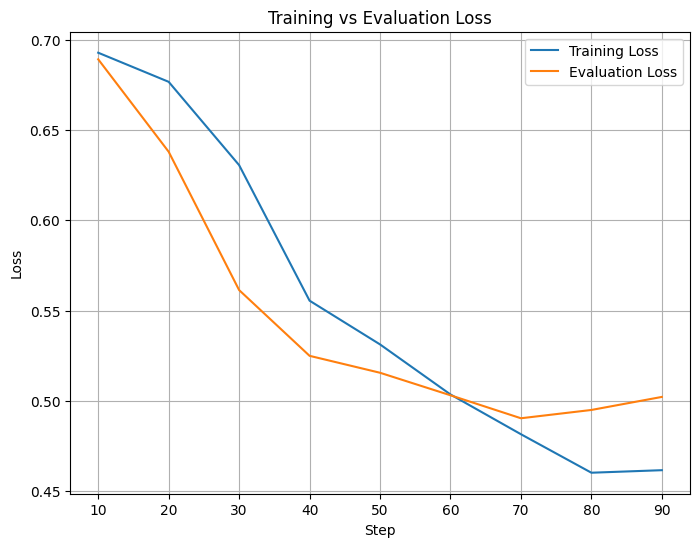

In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= dataset['train'],
    eval_dataset= dataset['validation'],
    tokenizer=tokenizer ,
    compute_metrics= compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)] #
)



trainer.train()
metrics = trainer.evaluate()
print(metrics)


# Extraemos los logs de entrenamiento
history = pd.DataFrame(trainer.state.log_history)

# A veces los logs pueden tener pasos donde no se evalúa. Filtramos filas con 'loss' y 'eval_loss'
train_loss = history[history['loss'].notna()][['step', 'loss']]
eval_loss = history[history['eval_loss'].notna()][['step', 'eval_loss']]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_loss['step'], train_loss['loss'], label='Training Loss')
plt.plot(eval_loss['step'], eval_loss['eval_loss'], label='Evaluation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training vs Evaluation Loss')
plt.legend()
plt.grid(True)
plt.show()


#save strategy val_loss ~5 epoch 80 objetivo

In [21]:
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.5022440552711487, 'eval_accuracy': 0.7753623188405797, 'eval_f1_score': 0.7816901408450704, 'eval_runtime': 15.1604, 'eval_samples_per_second': 18.205, 'eval_steps_per_second': 2.309, 'epoch': 5.0}


In [22]:
### estas son las metricas que estoy cogiendo.
trainer.evaluate(dataset['test'])

{'eval_loss': 0.5287688374519348,
 'eval_accuracy': 0.7318840579710145,
 'eval_f1_score': 0.75,
 'eval_runtime': 15.4708,
 'eval_samples_per_second': 17.84,
 'eval_steps_per_second': 2.262,
 'epoch': 5.0}

metricas
{'test_loss': 0.5287688374519348, 'test_accuracy': 0.7318840579710145, 'test_f1_score': 0.75, 'test_runtime': 14.8999, 'test_samples_per_second': 18.524, 'test_steps_per_second': 2.349}
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.67      0.71       135
           1       0.72      0.79      0.75       141

    accuracy                           0.73       276
   macro avg       0.73      0.73      0.73       276
weighted avg       0.73      0.73      0.73       276



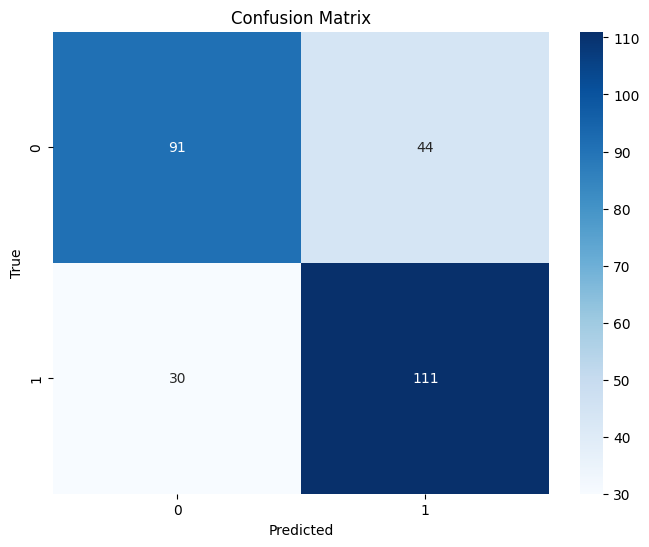

In [23]:
### Crear una matriz de confusión
# Obtener predicciones
predicciones_trainer = trainer.predict(dataset['test'])

print("metricas")
print(predicciones_trainer.metrics)

# Las predicciones pueden venir como logits, necesitamos el argmax
y_pred = np.argmax(predicciones_trainer.predictions, axis=1)
# Etiquetas verdaderas
y_true = predicciones_trainer.label_ids
cm = confusion_matrix(y_true, y_pred)

# print("Confusion Matrix:")
# print(cm)

print("Classification Report:")
print(classification_report(y_true, y_pred))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [24]:
# Ruta al checkpoint que quieres cargar
best_checkpoint_path = "mercadona_Brand_reference_detector/checkpoint-70"

# Cargar el modelo desde el checkpoint
model = AutoModelForSequenceClassification.from_pretrained(best_checkpoint_path)

# Volver a crear el Trainer con el modelo cargado
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= dataset['train'],
    eval_dataset= dataset['validation'],
    compute_metrics=compute_metrics
)

# Evaluar
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.4904356002807617, 'eval_model_preparation_time': 0.0057, 'eval_accuracy': 0.782608695652174, 'eval_f1_score': 0.781021897810219, 'eval_runtime': 14.3462, 'eval_samples_per_second': 19.239, 'eval_steps_per_second': 2.44}


In [25]:
### estas son las metricas que estoy cogiendo.
trainer.evaluate(dataset['test'])

#120


{'eval_loss': 0.5219426155090332,
 'eval_model_preparation_time': 0.0057,
 'eval_accuracy': 0.7536231884057971,
 'eval_f1_score': 0.7622377622377622,
 'eval_runtime': 14.8894,
 'eval_samples_per_second': 18.537,
 'eval_steps_per_second': 2.351}

metricas
{'test_loss': 0.5219426155090332, 'test_model_preparation_time': 0.0057, 'test_accuracy': 0.7536231884057971, 'test_f1_score': 0.7622377622377622, 'test_runtime': 14.9226, 'test_samples_per_second': 18.495, 'test_steps_per_second': 2.345}
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.73      0.74       135
           1       0.75      0.77      0.76       141

    accuracy                           0.75       276
   macro avg       0.75      0.75      0.75       276
weighted avg       0.75      0.75      0.75       276



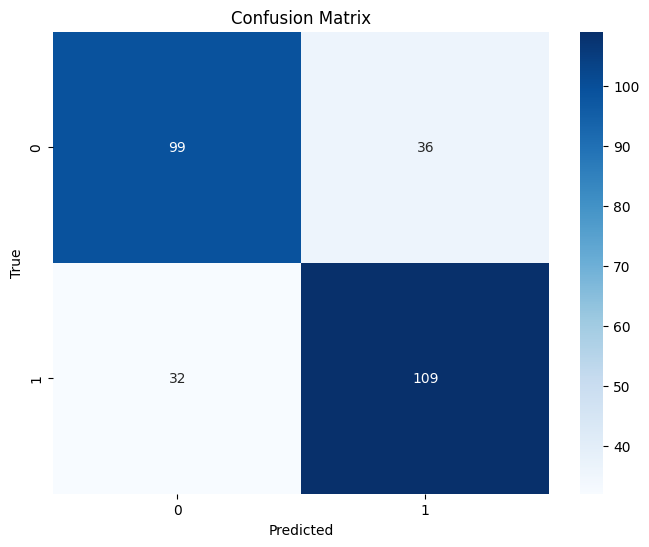

In [26]:
### Crear una matriz de confusión
# Obtener predicciones
predicciones_trainer = trainer.predict(dataset['test'])

print("metricas")
print(predicciones_trainer.metrics)

# Las predicciones pueden venir como logits, necesitamos el argmax
y_pred = np.argmax(predicciones_trainer.predictions, axis=1)
# Etiquetas verdaderas
y_true = predicciones_trainer.label_ids
cm = confusion_matrix(y_true, y_pred)

# print("Confusion Matrix:")
# print(cm)

print("Classification Report:")
print(classification_report(y_true, y_pred))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



In [30]:
# Predicción final (clase con mayor probabilidad)
y_pred = np.argmax(predicciones_trainer.predictions, axis=1)
y_true = predicciones_trainer.label_ids

# Obtener los textos originales
textos = dataset['test']['text']

# Crear un DataFrame para inspeccionar
df_resultados = pd.DataFrame({
    'texto': textos,
    'etiqueta_verdadera': y_true,
    'etiqueta_predicha': y_pred
})

falsos_positivos = df_resultados[(df_resultados.etiqueta_verdadera == 0) & (df_resultados.etiqueta_predicha == 1)]
falsos_negativos = df_resultados[(df_resultados.etiqueta_verdadera == 1) & (df_resultados.etiqueta_predicha == 0)]
falsos_negativos

,texto,etiqueta_verdadera,etiqueta_predicha
1,me he vuelto absolutamente fan de los cereales...,1,0
45,Podría estar todo el día comiendo polos flash ...,1,0
64,Porqué todo mi tl es x from mercadona.,1,0
73,Van todos vestidos de fin de año y el pintamon...,1,0
82,Me gustan los enfrentamientos y llevar al merc...,1,0
89,me acabo de acordar de que existe el turrón de...,1,0
99,Carlos Sadness la BSO oficial del mercadona,1,0
102,El jamón york del Mercadona lo único que veo e...,1,0
107,me estoy replanteando ir al otro mercadona.......,1,0
114,Yendo a dar un paseo x mercadona xq hace mucho...,1,0


In [32]:
falsos_positivos

,texto,etiqueta_verdadera,etiqueta_predicha
2,Multa en Mercadona por ir tres adultos. La exp...,0,1
3,"Gente que separa su compra de la tuya, con la ...",0,1
14,"Te deseo, rosca de reyes del Mercadona",0,1
18,Todas de rodillas en el Mercadona ahora mismo,0,1
23,Ponen cada temazo en el Mercadona dios,0,1
24,que la del mercadona nos ha echado xD,0,1
34,Hoy @Mercadona me ha roto el corazón por quita...,0,1
36,La quiche preparada del Mercadona es una de es...,0,1
38,mama por favo deha er vino asu der Mercadona,0,1
44,"Hola @Mercadona, por dejar unas cajas de plást...",0,1


In [27]:
from huggingface_hub import login
login(token="hf_")
# trainer.push_to_hub("mercadona_sentiment_product_detection_mini")

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...eference_detector/model.safetensors:   0%|          |  543kB / 2.25GB            

  ...eference_detector/training_args.bin:  12%|#1        |   628B / 5.37kB            

CommitInfo(commit_url='https://huggingface.co/MorcuendeA/mercadona_Brand_reference_detector/commit/fd227222245815e353e1d91f9a35aa3d5b078583', commit_message='mercadona_sentiment_product_detection_mini', commit_description='', oid='fd227222245815e353e1d91f9a35aa3d5b078583', pr_url=None, repo_url=RepoUrl('https://huggingface.co/MorcuendeA/mercadona_Brand_reference_detector', endpoint='https://huggingface.co', repo_type='model', repo_id='MorcuendeA/mercadona_Brand_reference_detector'), pr_revision=None, pr_num=None)